# NGBoost Classifier

By Alberto Valdés 

**Mail 1:** anvaldes@uc.cl 

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import time
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import image as mpimg

In [3]:
def display_img(name, a, b):
    plt.figure(figsize = (a, b))
    image = mpimg.imread(name)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

We present **Natural Gradient Boosting (NG- Boost)**, an algorithm for generic probabilistic prediction via gradient boosting.

The problem we are tackling here is that almost all regression algorithms do not return the distribution of the target variable given predictors $ \mathbb{P}(y|X)$, but an expectation of the target variable $\mathbb{E}(y|X)$.

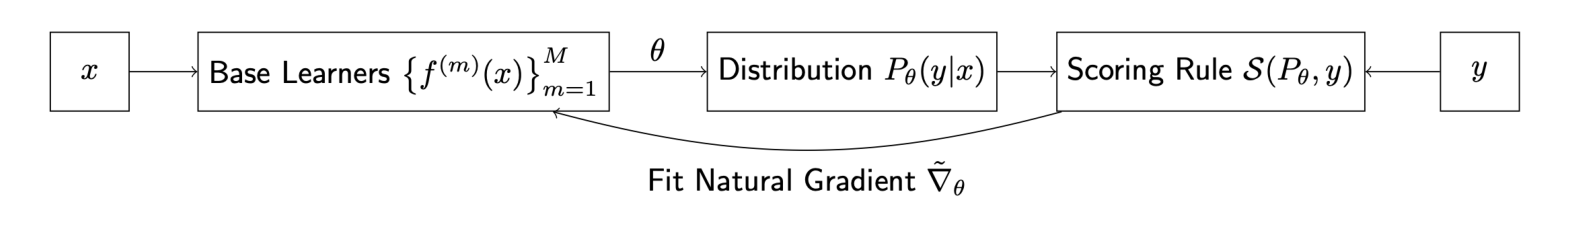

In [4]:
display_img('NGBoost.png', 20, 20)

**Considerations:**

- The trees aren't sensitive to scaling.
- This algorithm brings calibrator and balancetor.

In [5]:
start = time.time()

# 1. Preprocessing

### i. Read Dataframe

In [6]:
df = pd.read_csv('credit_risk.csv')

In [7]:
cat_str = ['person_home_ownership', 'loan_intent']
cat_oh = ['cb_person_default_on_file', 'loan_grade']

num_mean = ['person_age', 'person_income', 'loan_percent_income']

num_mean_nan = ['loan_int_rate', 'person_emp_length']
num_zero_nan = ['loan_amnt']

X_cols = cat_str + cat_oh + num_mean + num_mean_nan + num_zero_nan

label = 'loan_status'

### ii. Drop 'y' NaNs

In [8]:
df = df[df[label].notna()]

### iii. Split

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
features_dict = {
    'cat_str': cat_str,
    'cat_oh': cat_oh,
    'num_mean': num_mean,
    'num_mean_nan': num_mean_nan,
    'num_zero_nan': num_zero_nan
}

In [11]:
X = df[X_cols].copy()
y = df[label].copy()

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.40, random_state = 10)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.50, random_state = 10)

### iv. Fit preprocess

In [13]:
from preprocessing import *

In [14]:
transformers_pre = get_fit_transfomers(features_dict, X_train, y_train)

In [15]:
y_train = y_train.reset_index()
y_train = y_train.drop(columns = ['index'])

y_val = y_val.reset_index()
y_val = y_val.drop(columns = ['index'])

y_test = y_test.reset_index()
y_test = y_test.drop(columns = ['index'])

In [16]:
X_train = transform_datasets(transformers_pre, features_dict, X_train)

X_val = transform_datasets(transformers_pre, features_dict, X_val)

X_test = transform_datasets(transformers_pre, features_dict, X_test)

### v. Train model (with Fine Tunning)

In [17]:
from sklearn.metrics import f1_score

In [18]:
from ngboost import NGBClassifier

In [19]:
N_est_max = 100

In [20]:
N_est = [i for i in range(1, N_est_max + 1)]

In [21]:
threshold = round(y_val['loan_status'].mean(), 2)

In [22]:
all_f1_train = []
all_f1_val = []
all_params = []

for n_est in N_est:

    print('N estimators: ', n_est)

    clf = NGBClassifier(n_estimators = n_est, learning_rate = 0.2, random_state = 0, verbose = False)

    clf = clf.fit(X_train, y_train)

    y_train_pred_prob = clf.predict_proba(X_train)[:, 1]
    y_val_pred_prob = clf.predict_proba(X_val)[:, 1]

    y_train_pred = (y_train_pred_prob >= threshold)*1
    y_val_pred = (y_val_pred_prob >= threshold)*1

    f1_train = f1_score(y_train, y_train_pred)
    f1_val = f1_score(y_val, y_val_pred)

    all_f1_train.append(f1_train)
    all_f1_val.append(f1_val)
    all_params.append([n_est])
    
    print('-'*70)

all_f1_train = np.array(all_f1_train)
all_f1_val = np.array(all_f1_val)
all_params = np.array(all_params)

N estimators:  1
----------------------------------------------------------------------
N estimators:  2
----------------------------------------------------------------------
N estimators:  3
----------------------------------------------------------------------
N estimators:  4
----------------------------------------------------------------------
N estimators:  5
----------------------------------------------------------------------
N estimators:  6
----------------------------------------------------------------------
N estimators:  7
----------------------------------------------------------------------
N estimators:  8
----------------------------------------------------------------------
N estimators:  9
----------------------------------------------------------------------
N estimators:  10
----------------------------------------------------------------------
N estimators:  11
----------------------------------------------------------------------
N estimators:  12
------------

In [23]:
f1_train_opt = all_f1_train[all_f1_val == all_f1_val.max()][0]
f1_val_opt = all_f1_val[all_f1_val == all_f1_val.max()][0]
N_est_opt = all_params[all_f1_val == all_f1_val.max()][0][0]

In [24]:
print('F1 Train:', round(f1_train_opt*100, 2))
print('F1 Val:', round(f1_val_opt*100, 2))
print('N est opt:', N_est_opt)
print('Threshold:', threshold)

F1 Train: 74.43
F1 Val: 75.02
N est opt: 20
Threshold: 0.22


### vi. Train definitive model

In [25]:
clf = NGBClassifier(n_estimators = N_est_opt, learning_rate = 0.2, random_state = 0, verbose = False)

In [26]:
clf = clf.fit(X_train, y_train)

In [27]:
y_train_pred_prob = clf.predict_proba(X_train)[:, 1]
y_val_pred_prob = clf.predict_proba(X_val)[:, 1]
y_test_pred_prob = clf.predict_proba(X_test)[:, 1]

y_train_pred = (y_train_pred_prob >= threshold)*1
y_val_pred = (y_val_pred_prob >= threshold)*1
y_test_pred = (y_test_pred_prob >= threshold)*1

f1_train = f1_score(y_train, y_train_pred)
f1_val = f1_score(y_val, y_val_pred)
f1_test = f1_score(y_test, y_test_pred)

In [28]:
print('F1 Train:', round(f1_train*100, 2))
print('F1 Val:', round(f1_val*100, 2))
print('F1 Test:', round(f1_test*100, 2))

F1 Train: 74.43
F1 Val: 75.02
F1 Test: 74.91


### vii. Calibration

How the model have a calibrator, this step it's not necessary.

### viii. Report Calibration

In [29]:
from sklearn.calibration import calibration_curve

In [30]:
def calibration(y, y_pred):

    scores, probs = calibration_curve(y, y_pred, n_bins = 10, normalize = True)

    plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect Calibration')
    plt.plot(probs, scores, marker = '.', label = 'Real Calibration')
 
    leg = plt.legend(loc = 'upper left')

    plt.xlabel('Probability on each bin')
    plt.ylabel('Real probability on each bin')

    plt.title('Calibration')
    plt.show()

**Train:**

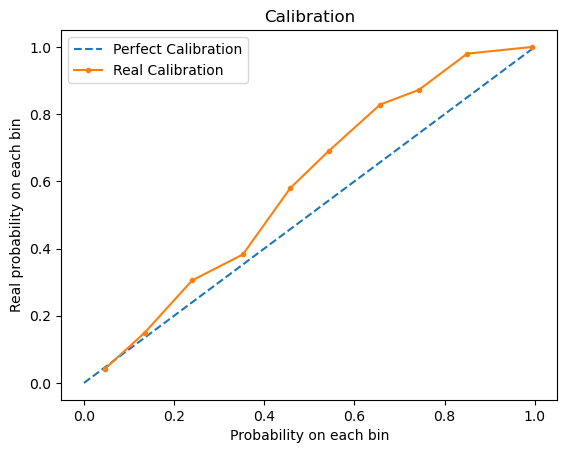

In [31]:
calibration(y_train, y_train_pred_prob)

**Val:**

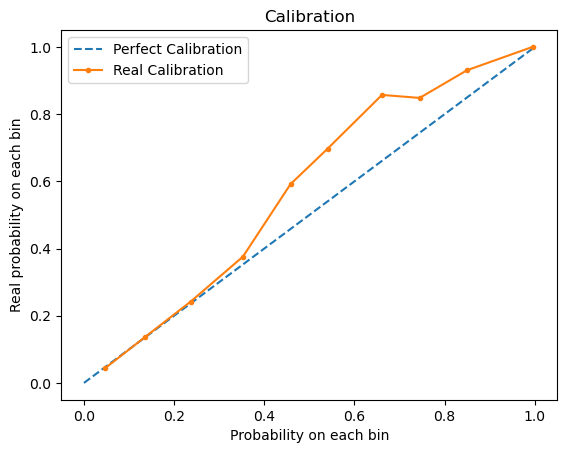

In [32]:
calibration(y_val, y_val_pred_prob)

**Test:**

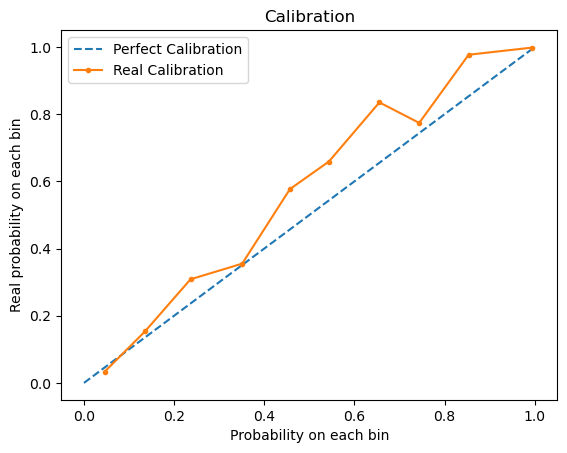

In [33]:
calibration(y_test, y_test_pred_prob)

### ix. Confidence Interval

When we have the probabilities $(MP)$ given by a model and the real probabilities $(RP)$ we can define the next random variable:

$ e = RP - MP $

When we have $n$ observations we have:

$ e_i = RP_i - MP_i \ \forall i \in \lbrace 1, ..., n \rbrace $

We can compute $ S $ and $ \bar{e} $ as follows:

$ \bar{e} = \frac{1}{n} \sum_{i=1}^n e_i $

$ S = \sqrt{\cfrac{1}{(n-1)} \cdot \sum_{i=1}^n (e_i - \bar{e})^2} $

Asumming $ e \sim Normal $ we can say that:

$ \bar{e} - S \cdot 1.96 + MP_i \leq RP_i \leq \bar{e} + S \cdot 1.96 + MP_i $     $ \forall i \in \lbrace 1, ..., n \rbrace$  with $ 95 \% $ of confidence.

And also:

$ \bar{e} - \cfrac{S}{\sqrt{n}} \cdot 1.96 + \bar{MP} \leq \bar{RP} \leq \bar{e} + \cfrac{S}{\sqrt{n}} \cdot 1.96 + \bar{MP} $  with $ 95 \% $ of confidence.

In [34]:
real_probs_val, model_probs_val = calibration_curve(y_val, y_val_pred_prob, n_bins = 100, normalize = True)

In [35]:
df_ci_val = pd.DataFrame(zip(model_probs_val, real_probs_val))
df_ci_val = df_ci_val.rename(columns = {0: 'model_prob', 1: 'real_prob'})
df_ci_val['error'] = df_ci_val['real_prob'] - df_ci_val['model_prob']

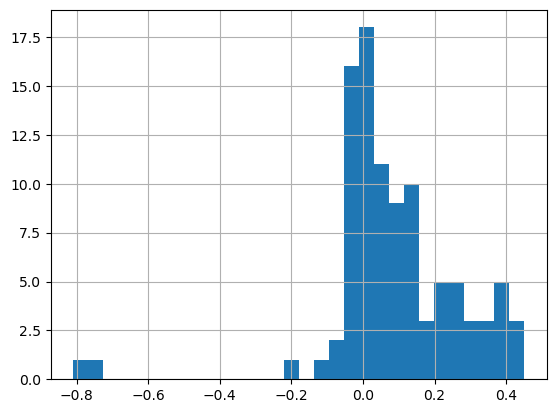

In [36]:
df_ci_val['error'].hist(bins = 30)
plt.show()

**Comments:** The distribution are very similar to a Normal.

In [37]:
bar_e = df_ci_val['error'].mean()
S = df_ci_val['error'].std()

In [38]:
round(bar_e*100, 2), round(S*100, 2)

(8.73, 19.08)

### x. Patterns

**Loan Grade vs Loan Status**

In [39]:
X_test['predict'] = y_test_pred

In [40]:
round(X_test[X_test['loan_grade_A'] == 1]['predict'].mean()*100, 2)

6.93

In [41]:
round(X_test[X_test['loan_grade_B'] == 1]['predict'].mean()*100, 2)

11.86

In [42]:
round(X_test[X_test['loan_grade_C'] == 1]['predict'].mean()*100, 2)

18.0

In [43]:
round(X_test[X_test['loan_grade_D'] == 1]['predict'].mean()*100, 2)

84.87

In [44]:
round(X_test[X_test['loan_grade_E'] == 1]['predict'].mean()*100, 2)

90.23

In [45]:
round(X_test[X_test['loan_grade_F'] == 1]['predict'].mean()*100, 2)

85.0

In [46]:
round(X_test[X_test['loan_grade_G'] == 1]['predict'].mean()*100, 2)

94.74

In [47]:
X_test = X_test.drop(columns = ['predict'])

### xi. Feature importance

In [48]:
fi = pd.DataFrame(zip(X_train.columns, clf.feature_importances_.sum(axis = 0)/2))
fi = fi.rename(columns = {0: 'Variable', 1: 'Importance'})
fi['Importance'] = fi['Importance']*100

fi = fi.sort_values(by = ['Importance'], ascending = False)
fi = fi.reset_index()
fi = fi.drop(columns = ['index'])

In [49]:
fi

,Variable,Importance
0,person_home_ownership,15.786694
1,loan_percent_income,14.670730
2,person_income,6.999208
3,loan_int_rate,4.064323
4,loan_intent,3.030084
5,loan_grade_D,2.124690
6,loan_grade_A,1.027594
7,loan_grade_E,0.843958
8,loan_grade_G,0.554805
9,loan_grade_F,0.501054


### xii. Explainability

In [50]:
import shap

In [51]:
explainer = shap.TreeExplainer(clf)

In [52]:
shap_values = explainer.shap_values(X_test)

In [53]:
df_shap_values = pd.DataFrame(shap_values)

In [54]:
df_shap_values.columns = X_test.columns

**Importance Variable**

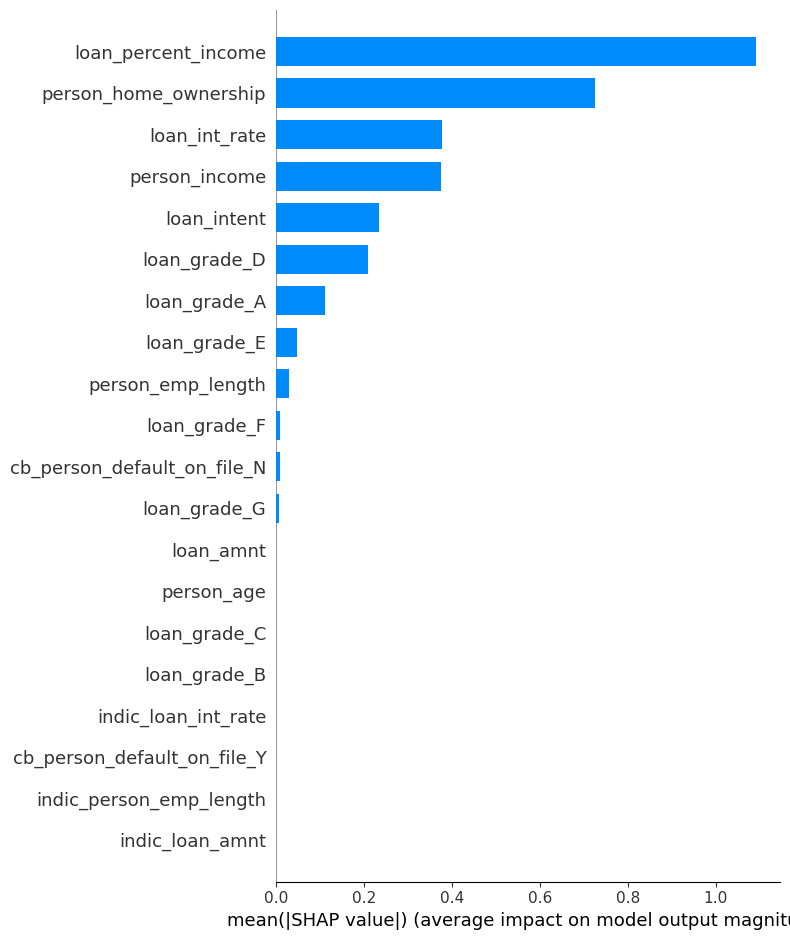

In [55]:
shap.summary_plot(shap_values, X_test, plot_type = "bar")

In [56]:
df_shap_values['partial_sum_SHAP'] = df_shap_values.sum(axis = 1)

In [57]:
df_shap_values = df_shap_values[['partial_sum_SHAP']]

In [58]:
df_shap_values['prob_model'] = y_test_pred_prob

**Sum of SHAP Values**

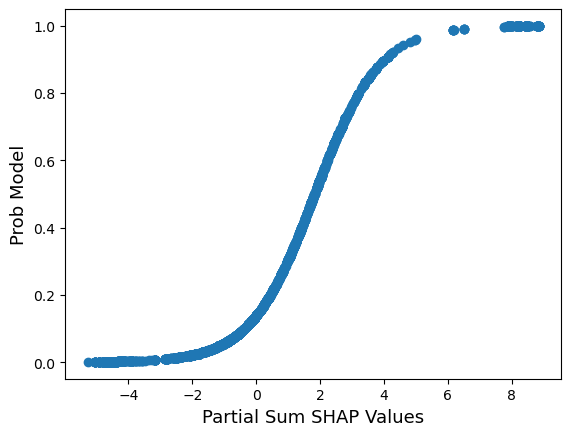

In [59]:
plt.scatter(df_shap_values['partial_sum_SHAP'], df_shap_values['prob_model'])
plt.xlabel('Partial Sum SHAP Values', fontsize = 13)
plt.ylabel('Prob Model', fontsize = 13)
plt.show()

**SHAP dependency**

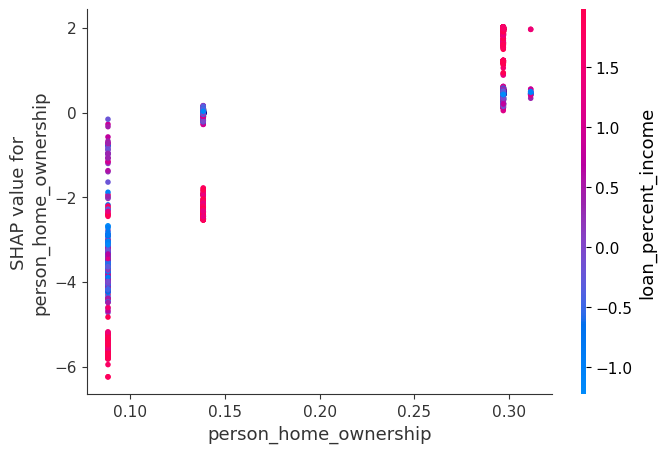

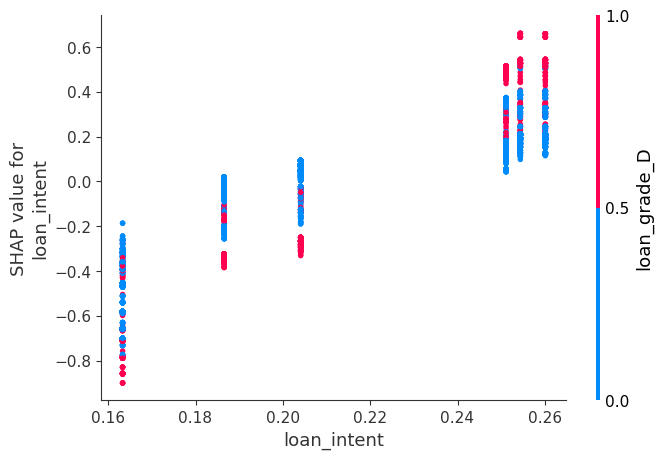

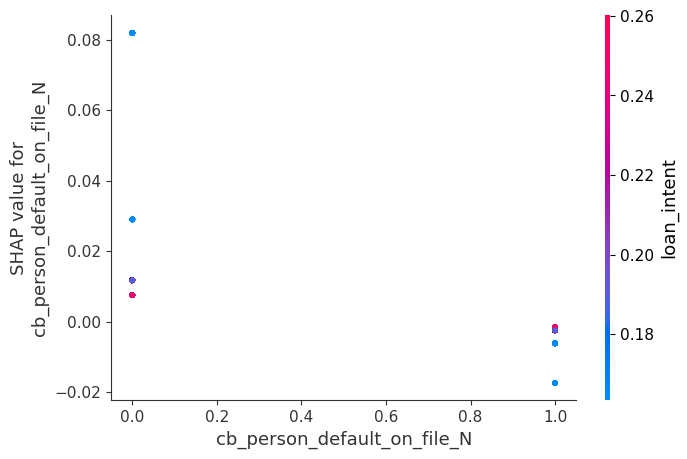

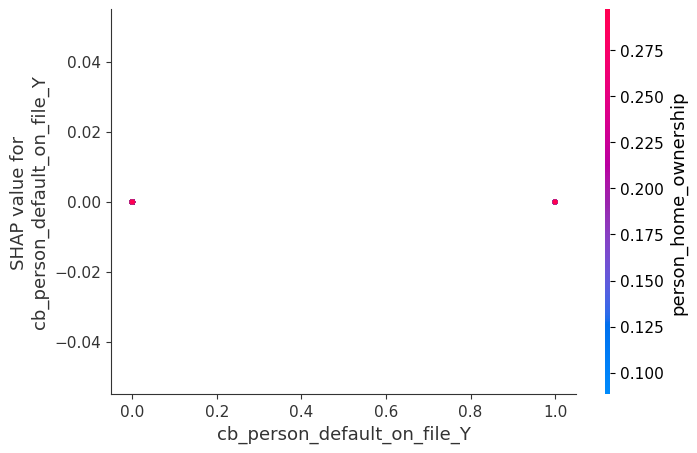

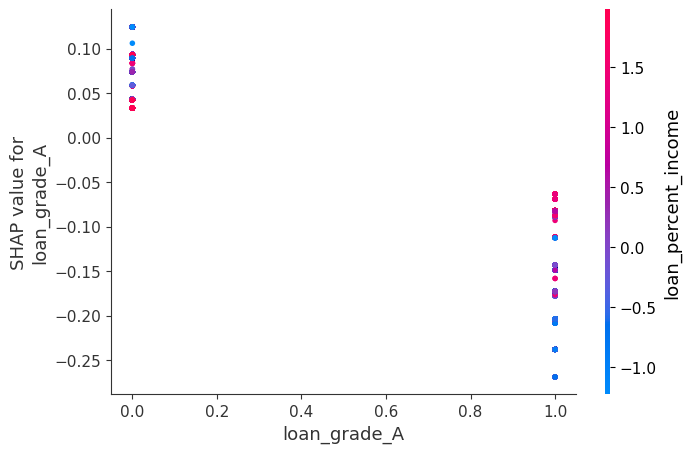

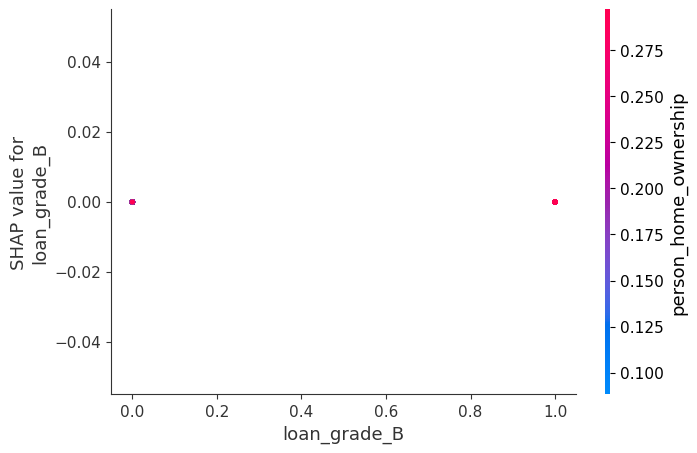

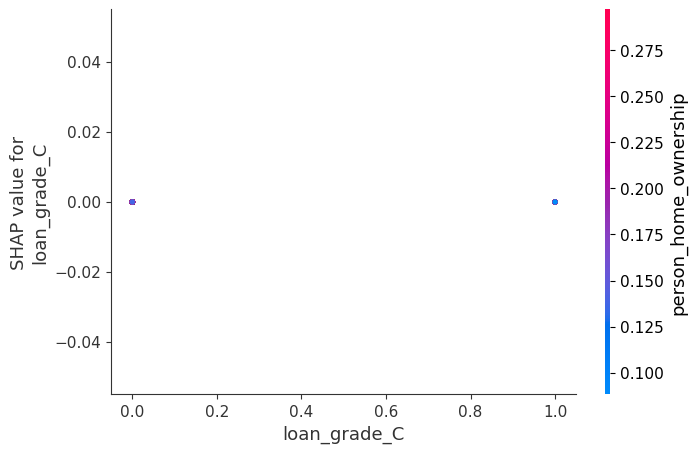

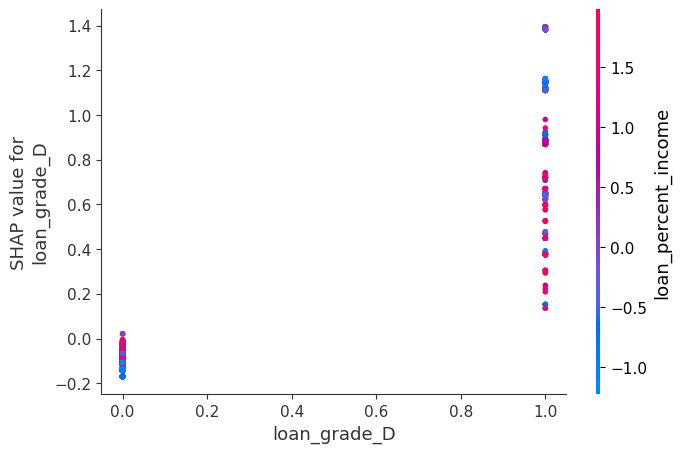

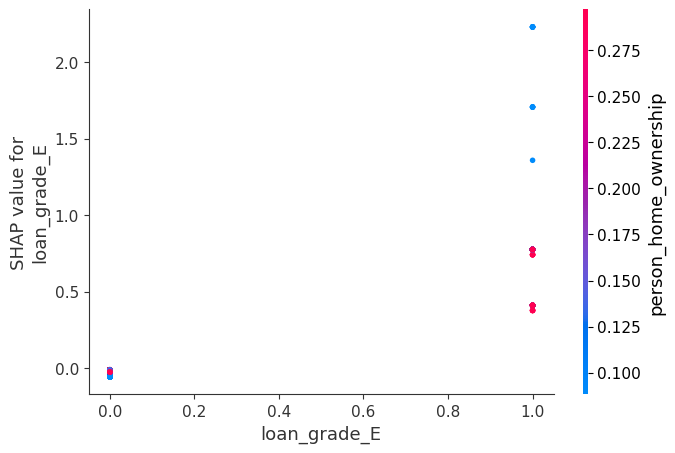

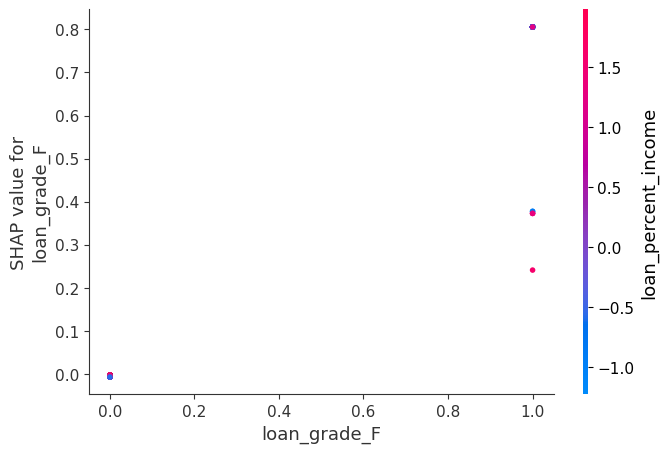

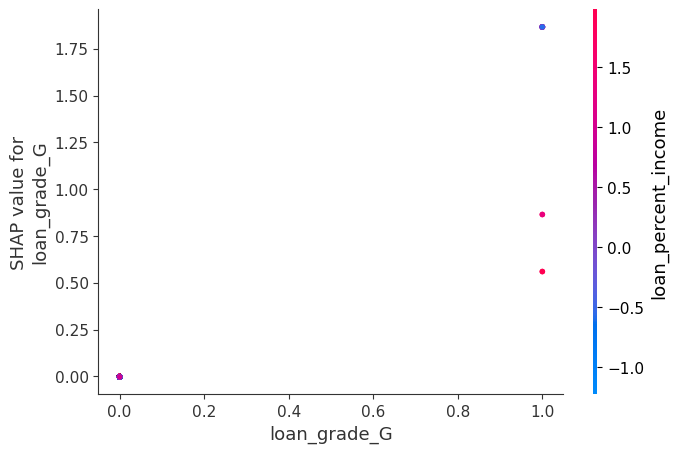

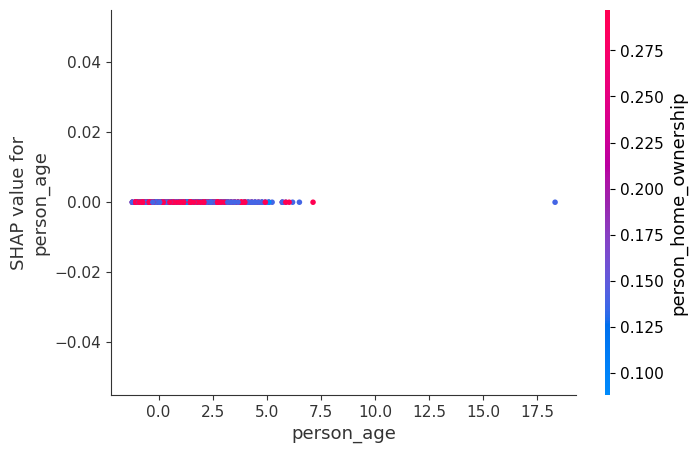

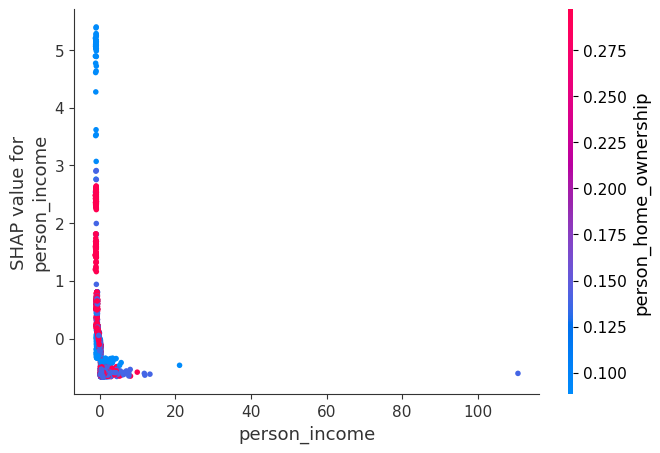

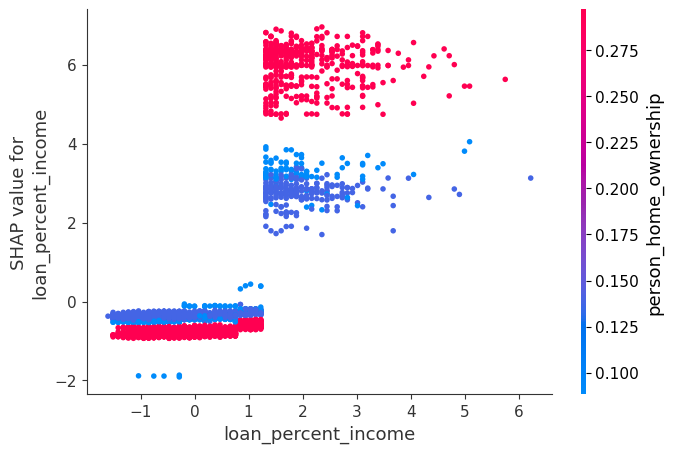

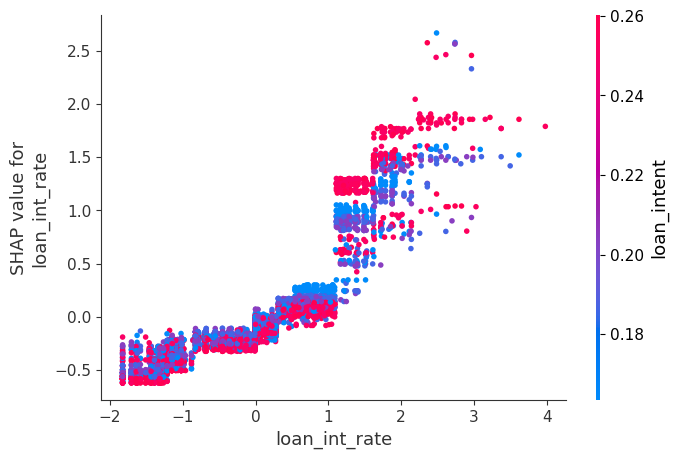

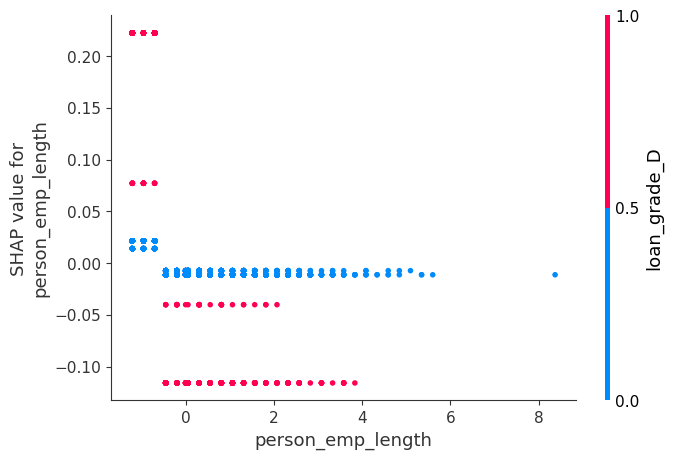

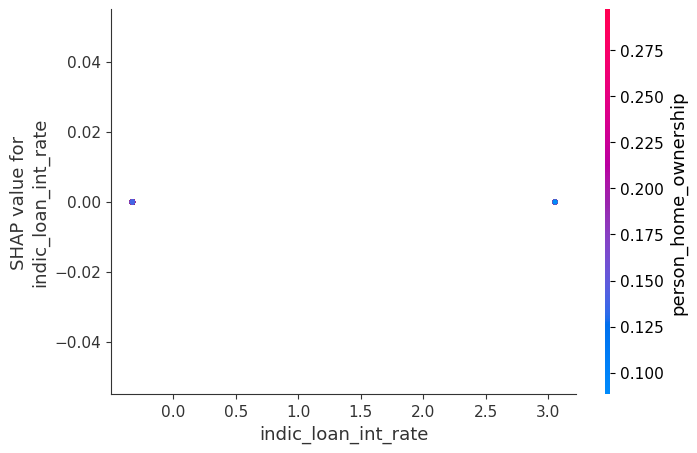

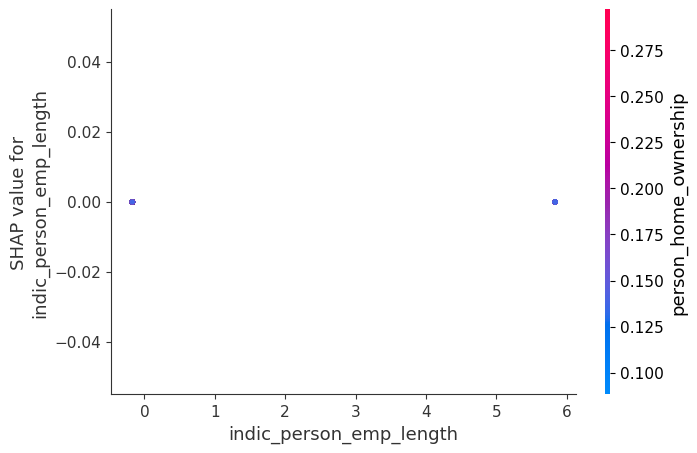

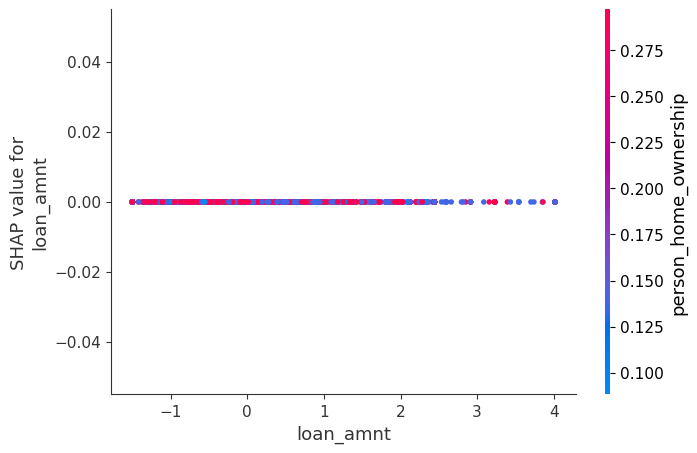

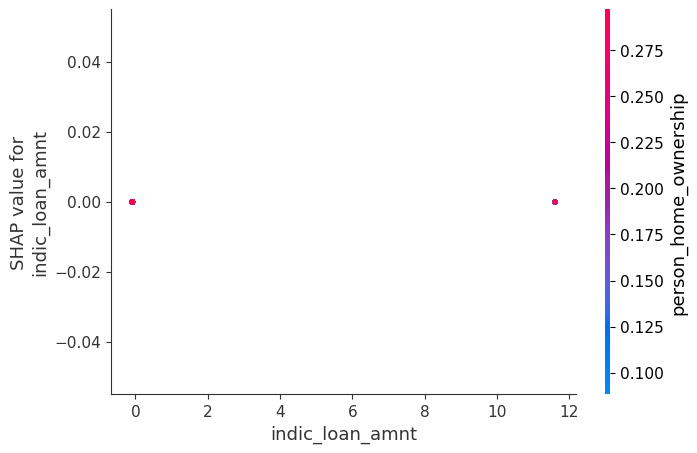

In [60]:
for name in X_test.columns:
    shap.dependence_plot(name, shap_values, X_test)

### Time of execution

In [61]:
end = time.time()

In [62]:
delta = (end - start)

hours = int(delta/3600)
mins = int((delta - hours*3600)/60)
segs = int(delta - hours*3600 - mins*60)
print(f'Execute this notebook take us {hours} hours, {mins} minutes and {segs} seconds.')

Execute this notebook take us 0 hours, 3 minutes and 12 seconds.
